# HW2Q7 c
### import library

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

### constants

In [6]:
EPSILON = 0.01
MAX_ITER = 1000000
RHO = 0.01

### functions

In [7]:
def phi_func(row, n_degree):
    if n_degree == -1:
        return row
    else:
        result = np.array([])
        for i in row:
            for j in range(1, n_degree + 1):
                result = np.concatenate([result, [np.power(i, j)]])
        return np.concatenate([result, [1]])


def feature_normalization(trn, tst, val):
    for i in range(0, len(trn[0]) - 1):
        avg = np.mean(trn[:, i])
        max_minus_min = np.max(trn[:, [i]]) - np.min(trn[:, [i]])
        trn[:, [i]] = (trn[:, [i]] - avg) / max_minus_min
        tst[:, [i]] = (tst[:, [i]] - avg) / max_minus_min
        val[:, [i]] = (val[:, [i]] - avg) / max_minus_min
    return trn, tst, val


def linear_reg(data, s, lam_da, n_degree=-1, gd_rho=RHO):
    data_copy = data.copy()
    for key in ['X_trn', 'X_tst', 'X_val']:
        data_copy[key] = np.apply_along_axis(phi_func, 1, data_copy[key], n_degree)
    # feature normalization:
    x_trn = data_copy['X_trn']
    x_tst = data_copy['X_tst']
    x_val = data_copy['X_val']
    x_trn, x_tst, x_val = feature_normalization(x_trn, x_tst, x_val)
    data_copy['X_trn'] = x_trn
    data_copy['X_tst'] = x_tst
    data_copy['X_val'] = x_val
    # start regression:
    if s == 0:
        return (data_copy,) + closed_form_reg(data_copy, lam_da)
    elif s == 1:
        return (data_copy,) + gradient_descent_reg(data_copy, lam_da, rho=gd_rho)


def closed_form_reg(data, lam_da):
    theta_star = closed_form_theta(data, lam_da)
    err_trn, err_tst, err_val = calc_error(data, theta_star)
    return theta_star, err_trn, err_tst, err_val


def closed_form_theta(data, lam_da):
    x_trn = data['X_trn']
    y_trn = data['Y_trn']
    xtx = np.matmul(x_trn.transpose(), x_trn)
    l_id = lam_da * np.eye(len(xtx[0]), dtype=float)
    inv = np.linalg.inv(xtx + l_id)
    theta_star_mat = np.matmul(inv, np.matmul(x_trn.transpose(), y_trn))
    return theta_star_mat


def calc_error(data, theta):
    x_train = data['X_trn']
    x_test = data['X_tst']
    x_val = data['X_val']
    y_train = data['Y_trn']
    y_test = data['Y_tst']
    y_val = data['Y_val']
    err_train = calc_error_xytheta(x_train, y_train, theta)
    err_test = calc_error_xytheta(x_test, y_test, theta)
    err_val = calc_error_xytheta(x_val, y_val, theta)
    return err_train, err_test, err_val


def calc_error_xytheta(x_mat, y_mat, theta_mat):
    err_mat = np.subtract(y_mat, np.matmul(theta_mat.transpose(), x_mat.transpose()).transpose())
    err = np.power(np.linalg.norm(err_mat), 2) / len(err_mat)
    return err


def gradient_descent_reg(data, lamb_da, max_iter=MAX_ITER, rho=RHO, epsilon=EPSILON):
    x_train = data['X_trn']
    y_train = data['Y_trn']
    curr_theta = np.full((len(x_train[0]), 1), 0)
    i = 1
    for i in range(0, max_iter):
        new_theta, new_dir = single_descent(curr_theta, rho, x_train, y_train, lamb_da)
        curr_theta = new_theta
        if np.linalg.norm(new_dir) < epsilon:
            print("The total number of iterations is: {} with rho = {}".format(i + 1, rho))
            break
    if i >= max_iter - 1:
        print("Exceeds max iteration: {}; with learning rate: {}".format(max_iter, rho))
    err_trn, err_tst, err_val = calc_error(data, curr_theta)
    return curr_theta, err_trn, err_tst, err_val


def single_descent(curr_theta, rho, x, y, lamb_da):
    xt_x = np.matmul(x.transpose(), x)
    xt_y = np.matmul(x.transpose(), y)
    new_dir = (np.matmul(xt_x, curr_theta) - xt_y) + lamb_da * curr_theta
    theta = curr_theta - new_dir * rho
    return theta, new_dir


def plot_regression(data, theta, title=""):
    # plot scatter point from data set
    x = data['x']
    y = data['y']
    x_first_col = x[:, [0]]
    plt.scatter(x_first_col, y)
    # plot line generated from theta
    theta_x = np.array([np.arange(-1, 1, 0.01)]).transpose()
    expanded_x = np.apply_along_axis(phi_func, 1, theta_x, len(theta) - 1)
    theta_y = np.matmul(expanded_x, theta)
    plt.plot(list(theta_x), list(theta_y))
    plt.title(title)
    plt.show()

### calculating theta on different lambdas
I am using the n-powering then normalizing method to compare lambdas.

I am only looking at the closed form result to decided which is the best lambda in the following code.

In [15]:
d1 = sio.loadmat('./data/dataset_hw2.mat')
d1.pop('__header__')
d1.pop('__version__')
d1.pop('__globals__')

closed_val_err_list = []
gd_val_err_list = []
lambda_list =  [0.001, 0.01, 0.1, 1, 10, 100]
for lamb_da in lambda_list:
    print('n = 7, lambda = {}'.format(lamb_da))
    print("closed form calculation:")
    data_copy, theta_star, err_trn, err_tst, err_val = linear_reg(d1, 0, lamb_da, n_degree=7)
    closed_val_err_list.append(err_val)
    print("theta transpose = \n {}".format(theta_star.transpose()))
    print("validation error: {}".format(err_val))
    print("gradient descent calculation:")
    data_copy, theta_star, err_trn, err_tst, err_val = linear_reg(d1, 1, lamb_da, n_degree=7)
    gd_val_err_list.append(err_val)
    print("theta transpose = \n {}".format(theta_star.transpose()))
    print("validation error: {}".format(err_val))
    print("\n")

n = 7, lambda = 0.001
closed form calculation:
theta transpose = 
 [[-12.02177495  -2.28031535  11.26864355  -0.04746883   3.89040996
   -0.21904507  -3.01925951  -0.69673862]]
validation error: 0.02298079933690731
gradient descent calculation:
The total number of iterations is: 11919 with rho = 0.01
theta transpose = 
 [[-11.9301781   -2.2723808   10.93431306  -0.06482099   4.0865917
   -0.20978331  -2.94452463  -0.69673862]]
validation error: 0.022613312772216797


n = 7, lambda = 0.01
closed form calculation:
theta transpose = 
 [[-11.17331313  -2.19811369   8.9002535   -0.18623712   4.00157816
   -0.16275876  -1.38343455  -0.69663413]]
validation error: 0.02385600112687813
gradient descent calculation:
The total number of iterations is: 9263 with rho = 0.01
theta transpose = 
 [[-11.10998774  -2.19246094   8.70899703  -0.19825358   4.01015714
   -0.1567974   -1.24026461  -0.69663413]]
validation error: 0.024282624330997954


n = 7, lambda = 0.1
closed form calculation:
theta transp

### Draw the validation error as a function of the regularization parameter
The x label is -3, -2, -1, 1,2,3 each representing the power of 10. i.e. -3 -> 10^{-3}

NOTE: there is no data for 10^0

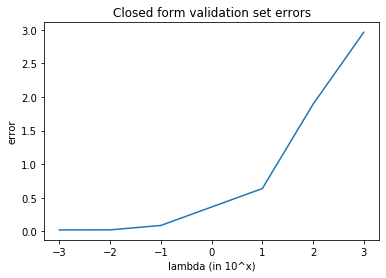

In [17]:
plt.plot(np.array([-3,-2,-1,1,2,3]), closed_val_err_list)
plt.title("Closed form validation set errors")
plt.xlabel('lambda (in 10^x)')
plt.ylabel('error')
plt.show()

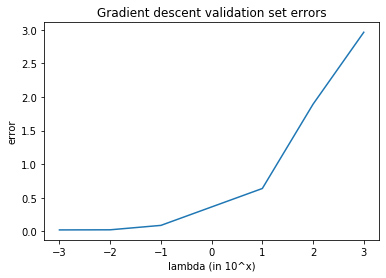

In [18]:
plt.plot(np.array([-3,-2,-1,1,2,3]), gd_val_err_list)
plt.title("Gradient descent validation set errors")
plt.xlabel('lambda (in 10^x)')
plt.ylabel('error')
plt.show()

In [22]:
min_err_lambda = lambda_list[np.argmin(closed_val_err_list)]
print('n = 7, lambda = {} gives the best result'.format(min_err_lambda))
print("closed form calculation:")
data_copy, theta_star, err_trn, err_tst, err_val = linear_reg(d1, 0, min_err_lambda, n_degree=7)
print("theta transpose = \n {}".format(theta_star.transpose()))
print("testing error: {}".format(err_tst))

n = 7, lambda = 0.001 gives the best result
closed form calculation:
theta transpose = 
 [[-12.02177495  -2.28031535  11.26864355  -0.04746883   3.89040996
   -0.21904507  -3.01925951  -0.69673862]]
testing error: 0.02391661269397512
